In [53]:
from datasets import load_dataset
#access locaclly stored dataset in this path testing_for_error/asking_armor_data.json and is a json file

train_dataset = load_dataset("json", data_files="dataset_final_results/stratified_train.json")
val_dataset = load_dataset("json", data_files="dataset_final_results/stratified_val.json")
test_dataset = load_dataset("json", data_files="dataset_final_results/final_test.json")

In [2]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['Speaker', 'Event', 'Dialogue', 'Line_of_dialogue', 'Response_to', 'Race', 'Equipment', 'Condition', 'Result', 'Location', 'Tone'],
        num_rows: 1416
    })
})

In [3]:
val_dataset

DatasetDict({
    train: Dataset({
        features: ['Speaker', 'Event', 'Dialogue', 'Line_of_dialogue', 'Response_to', 'Race', 'Equipment', 'Condition', 'Result', 'Location', 'Tone'],
        num_rows: 176
    })
})

In [4]:
test_dataset

DatasetDict({
    train: Dataset({
        features: ['Speaker', 'Event', 'Dialogue', 'Line_of_dialogue', 'Response_to', 'Race', 'Game', 'Equipment', 'Monologue', 'Condition', 'Result', 'Context', 'Location', 'Tone'],
        num_rows: 186
    })
})

In [5]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [6]:
import wandb, os
wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

wandb: Currently logged in as: geoartopoulos (george-artop). Use `wandb login --relogin` to force relogin


In [7]:
def formatting_func(example):

    # if  example['Monologue'] is not None:
    #     return f"""
# In the following text, there is a description about introductory monologues in video games. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the title of the current game will always be enclosed inside " ", the monologue will always be enclosed inside $ $, and the context will be enclosed inside # #.
# 
# <START>
# In video games, sometimes there is an introductory monologue delivered by a Speaker. The Speaker can either be an unknown narrator or a character in the game, and they introduce the Player to the world, the story, and the setting of the game. For the game "{example['Game']}", the introductory monologue is as follows:
# 
# ${example['Monologue']}$
# 
# This monologue is based on the game's setting, world, story, and the Player's role in the game. Here is some context describing these elements:
# 
# #{example['Context']}#
# <END>"""



    description = f"""The following text elaborates on what line of dialogue is used by an NPC in a certain event. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the speaker will be enclosed inside % %, the line spoken will be enclosed inside " ".

"""
    if example['Event'] == "Greeting":

        description = f"""The following text describes a greeting exchange between the Player and an NPC. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the type of speaker will be enclosed inside % %, the line spoken will be enclosed inside " ", and the tone of the line will be enclosed inside ; ;.

"""
    elif example['Event'] == "NPCs fighting over a Player's dropped item":

        description = f"""The following text describes an exchange where multiple NPCs are fighting over a Player's dropped item and one of them uses a line of dialogue. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the number of the current spoken line in the dialogue will be enclosed inside ~ ~, the line spoken will be enclosed inside " ", and the speaker will be enclosed inside % %.

"""
    elif example['Condition'] == "in combat":

        description = f"""The following text elaborates on which line of dialogue a friendly NPC uses when it is in combat. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the condition will be enclosed inside ( ), the line spoken will be enclosed inside " ", and the speaker will be enclosed inside % %.

"""
    elif example['Result'] is not None:

        description = f"""The following text text elaborates on which line of dialogue is used by an NPC when the Player character tries to persuade them. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the line spoken will be enclosed inside " ", the result of the event will be enclosed inside @ @ and the speaker enclosed inside % %.

"""
    elif example['Race'] is not None:

        description = f"""The following text describes the reaction of a Guard based on the Player's race. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the speaker will be enclosed inside % %, the line spoken will be enclosed inside " ", the race of the Player will be enclosed inside * *, and the condition, if there is one, will be enclosed inside ( ).

"""
    elif example['Equipment'] is not None:

        description = f"""The following text describes the reaction of a Guard based on the Player's equipment. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the speaker will be enclosed inside % %, the line spoken will be enclosed inside " ", the equipment of the Player will be enclosed inside [ ], and the condition, if there is one, will be enclosed inside ( ).

"""
    elif example['Location'] is not None:

        description = f"""The following text describes a special interaction of a Guard based on the Player's location. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the speaker will be enclosed inside % %, the line spoken will be enclosed inside " ", the location of the Player will be enclosed inside ^ ^, and the condition, if there is one, will be enclosed inside ( ).

"""

    elif example['Response_to'] is not None:

        description = f"""The following text describes a part of a dialogue between and NPC and the Player in the case of a certain event. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the speaker will be enclosed inside % %, the line spoken will be enclosed inside " ", and the line that the speaker responds to, will be enclosed inside | |.

"""
    elif example['Condition'] is not None:

        description = f"""The following text elaborates on a line of dialogue used by an NPC in a certain event under a condition. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the speaker will be enclosed inside % %, the line spoken will be enclosed inside " ", and the condition, will be enclosed inside ( ).

"""


    if example['Speaker'] == "Any":

        npc_type = "the NPC, that is of any type"

    elif "Guard" in example['Speaker']:

        npc_type = f'the {example["Speaker"]}'

    elif "trainer" in example['Event']:

        npc_type = f"""the trainer NPC, that is named {example['Speaker']}"""

    elif example['Speaker'] == "Housecarl":

        npc_type = "the Housecarl"

    else:

        npc_type = f'the NPC, that is the type {example["Speaker"]}'



    if example['Event'] == "Greeting":

        return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the case of a &{example['Event']}&, between an NPC and the Player character, %{npc_type}% greets the Player with the following dialogue: {example['Dialogue']}, in a ;{example['Tone']}; tone.
<END>"""


    if example['Event'] == "Goodbye":

        return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the case of a &{example['Event']}&, between an NPC and the Player character,%{npc_type}% tells their goodbyes to the Player with the following dialogue: {example['Dialogue']}.
<END>"""


    if example['Event'] == "NPCs fighting over a Player's dropped item":

        return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of &{example['Event']}&, there can be up to 5 different NPCs arguing over an item that the Player character dropped and up to 2 bystander NPCs commenting on the situation. Up to five lines of dialogue can be exchanged between up to five different NPCs that are arguing and up to two lines of bystander dialogue can be used by up to two different bystander NPCs, meaning that the conversation ends after a maximum of 7 lines of dialogue have been said. In this case one of the NPCs that takes part in the arguing and %{npc_type}%, says the following line: {example['Dialogue']}, as the ~{example['Line_of_dialogue']}~ line of the dialogue.
<END>"""

    if example['Event'] == "NPC asking for the Player's dropped armor":

        if example['Speaker'] == "Player":
            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of an &{example['Event']}&, there is a conversation between the Player character and an NPC about the Player's dropped item.
In this case the %Player% character says the following line: {example['Dialogue']}, in response to the NPC's previous line of dialogue: |{example['Response_to']}|.
<END>"""

        if example['Response_to'] is not None:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of an &{example['Event']}& there is a conversation between the Player character and an NPC about the Player's dropped item.
In this case %{npc_type}%, says the following line: {example['Dialogue']}, in response to the Player character's previous line of dialogue: |{example['Response_to']}|.
<END>"""
        else:

            return description + f"""<<START>>
In the world of Skyrim from the game Elder Scrolls V, in the event of an &{example['Event']}& there is a conversation between the Player character and an NPC about the Player's dropped item.
In this case %{npc_type}%, says the following line: {example['Dialogue']}, to initiate a conversation about the Player's dropped item.
<END>"""

    if example['Condition'] == "in combat":

        return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when the Player character and a friendly NPC are ({example['Condition']}), %{npc_type}%, uses this line of dialogue: {example['Dialogue']}, when it is &{example['Event']}&.
<END>"""

    if example['Result'] is not None:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when the Player character tries to check if an NPC of any type can be persuaded, the %{npc_type}%, uses the following line of dialogue: {example['Dialogue']}, when &{example['Event']}& and as a result @{example['Result']}@.
<END>"""

    if example['Event'] == "an NPC spots the Player character having an amulet of mara":

        if example['Speaker'] == "Player":

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when &{example['Event']}& an interaction begins between the two about the possibility of marriage.
In this case the %Player% character, says the following line: {example['Dialogue']}, as a response to the the NPC's previous dialogue line: |{example['Response_to']}|.
<END>"""

        if example['Response_to'] is None:

            return description +  f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when &{example['Event']}& an interaction begins between the two about the possibility of marriage.
In this case %{npc_type}%, says the following line: {example['Dialogue']}, to initiate the conversation about marriage.
<END>"""

        else:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, when &{example['Event']}& an interaction begins between the two about the possibility of marriage.
In this case %{npc_type}%, says the following line: {example['Dialogue']}, as a response to the the Player's previous dialogue line: |{example['Response_to']}|.
<END>"""

    if example['Race'] is not None:

        if example['Condition'] is not None:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, Town Guards have special reactions to the race of the Player character, so in the case of &{example['Event']}& if the Player's race is *{example['Race']}*, the %Guard% reacts with this line of dialogue: {example['Dialogue']}, on the condition that the ({example['Condition']}).
<END>"""

        else:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, Town Guards have special reactions to the race of the Player character, so in the case of &{example['Event']}& if the Player's race is *{example['Race']}*, the %Guard% reacts with this line of dialogue: {example['Dialogue']}.
<END>"""

    if example['Equipment'] is not None:

        if example['Condition'] is not None:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, Town Guards have special reactions to the equipment the Player is holding or has equipped, so when in the case of a &{example['Event']}&, the %Guard% uses this line of dialogue: {example['Dialogue']}, to react to the Player's [{example['Equipment']}], on the condition that ({example['Condition']}).
<END>"""

        else:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, Town Guards have special reactions to the equipment the Player is holding or has equipped, so when in the case of a &{example['Event']}&, the %Guard% uses this line of dialogue: {example['Dialogue']}, to react to the Player's [{example['Equipment']}].
<END>"""

    if example['Location'] is not None:

        if example['Condition'] is not None:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, &Town Guards have special interactions with the Player character that are location based&, meaning that the Guards sometimes interact with the Player using town specific dialogue.
In this case a %Guard% in the town of ^{example['Location']}^ might use this line of dialogue: {example['Dialogue']}, when the Player interacts with them, on the condition that ({example['Condition']}).
<END>"""

        else:

            return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, &Town Guards have special interactions with the Player character that are location based&, meaning that the Guards sometimes interact with the Player using town specific dialogue.
In this case a %Guard% in the town of ^{example['Location']}^ might use this line of dialogue {example['Dialogue']}, when the Player interacts with them.
<END>"""

    if example['Condition'] is not None:

          return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of &{example['Event']}&, %{npc_type}%, says the following line to the Player character: {example['Dialogue']}, on the condition that ({example['Condition']}).
<END>"""

    return description + f"""<START>
In the world of Skyrim from the game Elder Scrolls V, in the event of &{example['Event']}&, %{npc_type}%, says the following line to the Player character: {example['Dialogue']}.
<END>"""

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token


`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
def generate_and_tokenize_prompt(prompt):
    print(formatting_func(prompt))
    return tokenizer(formatting_func(prompt))

In [10]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)

In [11]:
tokenized_val_dataset = val_dataset.map(generate_and_tokenize_prompt)

1592


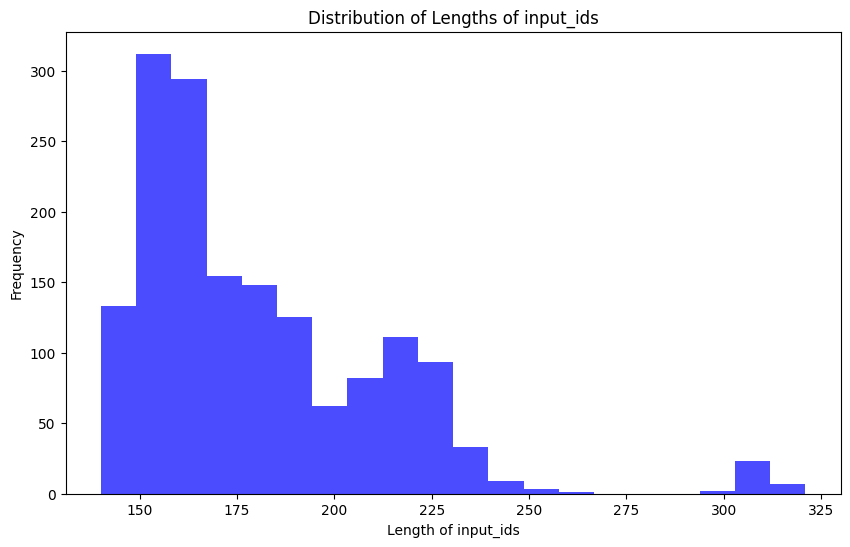

In [12]:
import matplotlib.pyplot as plt


def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset['train']]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset['train']]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [13]:
import numpy as np

lengths = [len(x['input_ids']) for x in tokenized_train_dataset['train']]

print(f"Mean: {np.mean(lengths)}")

# Calculate the 95th percentile
print(f"95th percentile: {np.percentile(lengths, 95)}")

# Calculate the max length
print(f"Max length: {np.max(lengths)}")

Mean: 181.06497175141243
95th percentile: 230.25
Max length: 321


In [14]:
max_length = 321  # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [16]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = val_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/1416 [00:00<?, ? examples/s]

1592


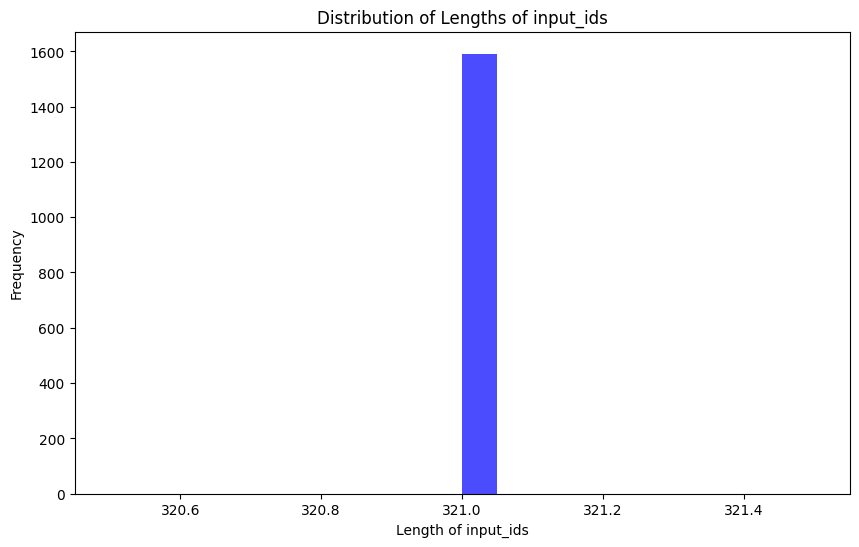

In [17]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [44]:
eval_prompt = (f"""The following text describes a greeting exchange between the Player and an NPC. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the type of speaker will be enclosed inside % %, the line spoken will be enclosed inside " ", and the tone of the line will be enclosed inside ; ;. Please fill the missing parts needed to complete the below text between <START> and <END>. 

<START>
In the world of Skyrim from the game Elder Scrolls V, in the case of a & &, between an NPC and the Player character, % % greets the Player with the following dialogue: " ", in a ; ; tone.
<END>

Answer:""")

In [45]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=321, repetition_penalty=1.15)[0],
                                skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


The following text describes a greeting exchange between the Player and an NPC. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the type of speaker will be enclosed inside % %, the line spoken will be enclosed inside " ", and the tone of the line will be enclosed inside ; ;. Please fill the missing parts needed to complete the below text between <START> and <END>. 

<START>
In the world of Skyrim from the game Elder Scrolls V, in the case of a & &, between an NPC and the Player character, % % greets the Player with the following dialogue: " ", in a ; ; tone.
<END>

Answer:
<START>
In the world of Skyrim from the game Elder Scrolls V, in the case of an encounter, between an NPC named Jorik and the Player character, Jorik greets the Player with the following dialogue: "Greetings traveler! I hope your journey through Skyrim has been a successful one.", in a friendly; welcoming tone.
<END>


In [18]:
# from peft import PeftConfig
# 
# adapter_model_id = "ybelkada/opt-350m-lora"
# peft_config = PeftConfig.from_pretrained(adapter_model_id)
# to initiate with random weights
# peft_config.init_lora_weights = False
# 
# model.add_adapter(peft_config)
# model.enable_adapters()

In [19]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [20]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [21]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

In [22]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


In [23]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer):

In [24]:
if torch.cuda.device_count() > 1:  # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [25]:
model = accelerator.prepare_model(model)

In [26]:
import transformers
from datetime import datetime

project = "NPC-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset["train"],
    eval_dataset=tokenized_val_dataset["train"],
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=3,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=591*2,
        learning_rate=2.5e-5,  # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,  # When to start reporting loss
        logging_dir="./logs",  # Directory for storing logs
        save_strategy="steps",  # Save the model checkpoint every logging step
        save_steps=50,  # Save checkpoints every 50 steps
        evaluation_strategy="steps",  # Evaluate the model every logging step
        eval_steps=50,  # Evaluate and save checkpoints every 50 steps
        do_eval=True,
        report_to="wandb",
        # Perform evaluation at the end of training 
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"  # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

C:\Users\Pumukl\AppData\Local\Programs\Python\Python312\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


C:\Users\Pumukl\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\Pumukl\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\mistral\modeling_mistral.py:688: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156
200,0.242000,0.268305


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156
200,0.242000,0.268305
250,0.216100,0.252031


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156
200,0.242000,0.268305
250,0.216100,0.252031
300,0.215500,0.238443


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156
200,0.242000,0.268305
250,0.216100,0.252031
300,0.215500,0.238443
350,0.179800,0.232428


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156
200,0.242000,0.268305
250,0.216100,0.252031
300,0.215500,0.238443
350,0.179800,0.232428
400,0.208500,0.229831


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156
200,0.242000,0.268305
250,0.216100,0.252031
300,0.215500,0.238443
350,0.179800,0.232428
400,0.208500,0.229831
450,0.179800,0.222132


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156
200,0.242000,0.268305
250,0.216100,0.252031
300,0.215500,0.238443
350,0.179800,0.232428
400,0.208500,0.229831
450,0.179800,0.222132
500,0.194400,0.215440


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156
200,0.242000,0.268305
250,0.216100,0.252031
300,0.215500,0.238443
350,0.179800,0.232428
400,0.208500,0.229831
450,0.179800,0.222132
500,0.194400,0.215440


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156
200,0.242000,0.268305
250,0.216100,0.252031
300,0.215500,0.238443
350,0.179800,0.232428
400,0.208500,0.229831
450,0.179800,0.222132
500,0.194400,0.215440


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156
200,0.242000,0.268305
250,0.216100,0.252031
300,0.215500,0.238443
350,0.179800,0.232428
400,0.208500,0.229831
450,0.179800,0.222132
500,0.194400,0.215440


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156
200,0.242000,0.268305
250,0.216100,0.252031
300,0.215500,0.238443
350,0.179800,0.232428
400,0.208500,0.229831
450,0.179800,0.222132
500,0.194400,0.215440


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156
200,0.242000,0.268305
250,0.216100,0.252031
300,0.215500,0.238443
350,0.179800,0.232428
400,0.208500,0.229831
450,0.179800,0.222132
500,0.194400,0.215440


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156
200,0.242000,0.268305
250,0.216100,0.252031
300,0.215500,0.238443
350,0.179800,0.232428
400,0.208500,0.229831
450,0.179800,0.222132
500,0.194400,0.215440


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156
200,0.242000,0.268305
250,0.216100,0.252031
300,0.215500,0.238443
350,0.179800,0.232428
400,0.208500,0.229831
450,0.179800,0.222132
500,0.194400,0.215440


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156
200,0.242000,0.268305
250,0.216100,0.252031
300,0.215500,0.238443
350,0.179800,0.232428
400,0.208500,0.229831
450,0.179800,0.222132
500,0.194400,0.215440


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156
200,0.242000,0.268305
250,0.216100,0.252031
300,0.215500,0.238443
350,0.179800,0.232428
400,0.208500,0.229831
450,0.179800,0.222132
500,0.194400,0.215440


Step,Training Loss,Validation Loss
50,0.475100,0.435544
100,0.335700,0.332950
150,0.238300,0.280156
200,0.242000,0.268305
250,0.216100,0.252031
300,0.215500,0.238443
350,0.179800,0.232428
400,0.208500,0.229831
450,0.179800,0.222132
500,0.194400,0.215440


KeyboardInterrupt: 

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-NPC-finetune/checkpoint-600")
model.config.use_cache = True  # silence the warnings. Please re-enable for inference!

In [42]:
eval_prompt = f"""The following text describes the event of a greeting between the Player and an NPC. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the type of speaker will be enclosed inside % %, the line spoken will be enclosed inside " ". Please fill the missing parts needed to complete the below text between <START> and <END>. 

<START>
In the world of Skyrim from the game Elder Scrolls V, in the case of a &Greeting&, between an NPC and the Player character, %FemaleNord% greets the Player with the following dialogue: " " in a ;Neutral; tone.
<END>

Answer: """
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=280, repetition_penalty=1.15)[0],
                                skip_special_tokens=True))
    #save the results to a list
    answer = eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=280, repetition_penalty=1.15)[0],
                                skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


The following text describes the event of a greeting between the Player and an NPC. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the event will be enclosed inside & &, the type of speaker will be enclosed inside % %, the line spoken will be enclosed inside " ". Please fill the missing parts needed to complete the below text between <START> and <END>. 

<START>
In the world of Skyrim from the game Elder Scrolls V, in the case of a &Greeting&, between an NPC and the Player character, %FemaleNord% greets the Player with the following dialogue: " " in a ;Neutral; tone.
<END>

Answer: 
<START>
In the world of Skyrim from the game Elder Scrolls V, in the case of a &Greeting&, between an NPC and the Player character, %FemaleNord% greets the Player with the following dialogue: "Hmm?", in a ;Neutral; tone.
<END>


# Rouge Score

In [49]:
def find_text_between_third_quotes(text,pair_num):
    # Split the text by quotes
    parts = text.split('"')
    
    # Check if there are at least six parts (to account for three pairs of quotes)
    if len(parts) >= pair_num*2:
        # Return the content between the third pair of quotes
        return parts[pair_num*2-1]  # parts[pair_num*2-1] because indexing starts at 0, and the text between the third pair is at index 5
    else:
        return "Not enough quotes in the text"

# Test the function
result = find_text_between_third_quotes(answer,3)

In [60]:
print(result)
generated_dialogues = [result]

Hmm?


In [61]:
# take the twelveth dialogue from the test dataset
reference = test_dataset['train']['Dialogue'][11]

#remove the quotes
reference = reference.replace('"', '')
print(reference)

Hmph.


In [62]:
reference_dialogues = reference

from rouge import Rouge

rouge = Rouge()
rouge_scores = rouge.get_scores(' '.join(generated_dialogues), ' '.join(reference_dialogues[0]))

# Output the scores 

print(f"ROUGE: {rouge_scores}")


ROUGE: [{'rouge-1': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.0, 'p': 0.0, 'f': 0.0}}]


In [ ]:
#

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.tokenize import word_tokenize

# Tokenize the reference and generated dialogues into words
reference_dialogues = [reference]

generated_dialogues = [result]

tokenized_references = word_tokenize(reference_dialogues[0])
tokenized_hypothesis = word_tokenize(generated_dialogues[0])

# Calculate BLEU score
bleu_score = sentence_bleu(tokenized_references, tokenized_hypothesis)
print(f"BLEU: {bleu_score}")